In [1]:
from sklearn.model_selection import train_test_split
import unittest
import numpy as np
from keras_performer import performer as tfr
import nltk

from os import listdir
from os.path import isfile, isdir, join
from nltk.tokenize import wordpunct_tokenize

nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import glob

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\W.R_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
'''
def solve_cudnn_error():
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
            
solve_cudnn_error()
'''

'\ndef solve_cudnn_error():\n    import tensorflow as tf\n    gpus = tf.config.experimental.list_physical_devices(\'GPU\')\n    if gpus:\n        try:\n            # Currently, memory growth needs to be the same across GPUs\n            for gpu in gpus:\n                tf.config.experimental.set_memory_growth(gpu, True)\n            logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n        except RuntimeError as e:\n            # Memory growth must be set before GPUs have been initialized\n            print(e)\n            \nsolve_cudnn_error()\n'

In [3]:
import csv
def readCSV(file_name):
    errlist=[]
    LBlist=[]
    with open(file_name, newline='') as csvfile:
    #讀取 CSV 檔內容，將每一列轉成一個 dictionary

        rows = csv.DictReader(csvfile)
        for row in rows: 
            RL=list(row.values())
            #print("RL[0]: ", type(RL[0]), "RL[1]: ", type(RL[1]))
            RL[1:] = list(map(int, RL[1:]))
            errs=RL[1:37]
            LB=RL[37:]
            errlist.append(errs)
            LBlist.append(LB)
    return errlist,LBlist


In [4]:
def find_first_sublist(seq, sublist, start=0):
    length = len(sublist)
    for index in range(start, len(seq)):
        if seq[index:index+length] == sublist:
            return index, index+length

In [5]:
def replace_sublist(seq, sublist, replacement):
    length = len(replacement)
    index = 0
    for start, end in iter(lambda: find_first_sublist(seq, sublist, index), None):
        seq[start:end] = replacement
        index = start + length

In [6]:
def replaceTAGS(x):
    replace_sublist(x, ['<', 'BOC', '>'], ["<BOC>"])
    replace_sublist(x, ['<', 'EOC', '>'], ["<EOC>"])
    replace_sublist(x, ['<', 'BOTM', '>'], ["<BOTM>"])
    replace_sublist(x, ['<', 'BOT', '>'], ["<BOT>"])
    replace_sublist(x, ['<', 'EOT', '>'], ["<EOT>"])
    replace_sublist(x, ['<', 'BOM', '>'], ["<BOM>"])
    replace_sublist(x, ['<', 'EOM', '>'], ["<EOM>"])
    replace_sublist(x, ['<', 'EOTM', '>'], ["<EOTM>"])
    replace_sublist(x, ['<', 'CR', '>'], ["<CR>"])
    return x

In [7]:
def parseSentence(x):	
    tokenizer = RegexpTokenizer(r"[\w']+|[].,:!?;=+-\\*/@#$%^&_(){}~|\"[]")
    tokens=[]
    state="START"
    chrs=""
    for i in range(len(x)):
        #print(ord(x[i]))
        if (ord(x[i])>255):
            inp="U"
        else:
            inp="E"

        if state=="START":
            if inp=="E":
                state="ASCII"
                chrs=x[i]
            else:
                state="UNICODE"
                tokens.append(x[i])

        elif state=="ASCII":
            if inp=="E":
                chrs += x[i]
            else:#U
                state="UNICODE"
                tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  #nltk.word_tokenize(chrs)
                chrs=""
                tokens.append(x[i])

        elif state=="UNICODE":
            if inp=="E":
                state="ASCII"
                chrs=x[i]
            else:
                state="UNICODE"
                tokens.append(x[i])
    if len(chrs)>0:
        tokens += tokenizer.tokenize(chrs) #wordpunct_tokenize(chrs)  # nltk.word_tokenize(chrs) 
    return tokens

In [8]:
def readcode(fname):
    with open(fname,encoding = 'utf-8') as f:
        data = f.read()
        return data

In [9]:
from matplotlib import pyplot as plt
def plotTrainingLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [10]:
def plotTrainingErrorLineAcc(history):
    #accuracy
    acc = [0.0]*360
    print("acc length: ", len(acc))
    for i in range(360):
        name = "LNout" + str(i) + "_accuracy"
        print("name: ", name)
        print("np.asarray(acc) shape: ", (np.asarray(acc)).shape)
        print("np.asarray(history.history[name] type: ", type(np.asarray(history.history[name])))
        print("np.asarray(history.history[name] shape: ", (np.asarray(history.history[name]).shape))
        print("np.asarray(history.history[name][0] : ", (np.asarray(history.history[name][0])))
        print("np.asarray(history.history[name][0] type : ", type(np.asarray(history.history[name][0])))
        print("np.asarray(history.history[name][1] : ", (np.asarray(history.history[name][1])))
        print("np.asarray(history.history[name][1] type : ", type(np.asarray(history.history[name][1])))
        acc = np.asarray(acc) + np.asarray(history.history[name][1])
    acc = list(acc/360)    
    plt.plot(acc) #draw acc
    #validation accuary
    val_acc = [0.0]*360
    for i in range(360):
        name = "val_LNout" + str(i) +"_accuracy"
        print("name: ", name)
        print("np.asarray(val_acc) shape: ", (np.asarray(val_acc)).shape)
        print("np.asarray(history.history[name] type: ", type(np.asarray(history.history[name])))
        print("np.asarray(history.history[name] shape: ", (np.asarray(history.history[name]).shape))
        print("np.asarray(history.history[name][0] : ", (np.asarray(history.history[name][0])))
        print("np.asarray(history.history[name][0] type : ", type(np.asarray(history.history[name][0])))
        print("np.asarray(history.history[name][1] : ", (np.asarray(history.history[name][1])))
        print("np.asarray(history.history[name][1] type : ", type(np.asarray(history.history[name][1])))
        val_acc = np.asarray(val_acc) + np.asarray(history.history[name][0])
    val_acc = list(val_acc/360)
    plt.plot(val_acc) #draw val_acc
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.show()

In [11]:
def plotTrainingErrorTypeAcc(history):
    plt.plot(history.history['error_feed_forward_output1_accuracy'])
    plt.plot(history.history['val_error_feed_forward_output1_accuracy'])
    plt.title('model error_feed_forward_output1_accuracy')
    plt.ylabel('error_feed_forward_output1_accuracy')
    plt.xlabel('epoch')
    plt.show()

In [12]:
import os
def listdir_fullpath(d):
    return [f for f in os.listdir(d)]

In [13]:
#save model for training
class TestTranslate(unittest.TestCase):
        
    def __init__(self):
        self.source_token_dict = {
            '<PAD>': 0,
            '<START>': 1,
            '<END>': 2,
            '<BOC>': 3,
            '<EOC>': 4,
            '<CR>': 5,
        }
        
    @staticmethod
    def _build_token_dict(token_dict, token_list):
        for tokens in token_list:
            for token in tokens:
                if token not in token_dict:
                    token_dict[token] = len(token_dict)
        return token_dict
    
    def test_translate(self):
        #print("i am here: " )
        #source_file=[]
        #Set Para
        max_javaline_length = 160 #Max number of lines
        #set path
        Output_Path = "Trianing\InputCSV\Split-500"
        Input_Path = "Trianing\InputTxt\Split-500"
        model_for_training_org_path = "Model-for-training-org\Split-500"
        model_for_training_path = "Model-for-training\Split-500"
        Trained_model_Path = "Trained_models\Spilt-500"
        #get all txt file in input path
        in_path = (glob.glob(Input_Path + "/**/*.txt"))
        #print("in_path: ", in_path)
        #cases = listdir_fullpath(Input_Path)
        source_max_len = 0
        target_max_len = 0
        token_num = 0
        all_sample_num = 16644 #all sample number
        block_num = 16644 #sample num e.g 10000 sample have 10*1000
        
        #''' <----dust switch, if you need to create npy model for traing open this
        self.sl = 0
        
        import math
        for loop in range(0, math.ceil(all_sample_num/block_num)): #new version 
        #for loop in range(0, round(336/block_num)): #old version
            print("First loop: ", loop)
            source_tokens = []
            target_errors = []
            target_LB = []
            if(all_sample_num % block_num == 0):
                dirs = block_num
            else:
                dirs = block_num if loop < all_sample_num // block_num else all_sample_num % block_num
            Input_fullpath = []
            Output_fullpath = []
            #print("dirs: ", dirs)
            for i in range(dirs):
                Input_fullpath.append(in_path[loop*block_num + i])                    
            for f in Input_fullpath:
                if isfile(f):
                    source_tokens.append(parseSentence(readcode(f)))
                    #print("source_tokens length: ", len(source_tokens))
                #if len(source_tokens)>max_files: break
            #get csv file     
            out_path = Output_Path + "/" + "test" + str(loop)+".csv"
            Output_fullpath = glob.glob(out_path)
            
            for f in Output_fullpath:
                if isfile(f):
                    err,lb = readCSV(f)
                    target_errors.append(err)
                    target_LB.append(lb)
                #if len(source_tokens)>max_files: break
            dd = np.asarray(target_errors)
            target_errors = target_errors[0]  
            target_LB = target_LB[0]     
            
            # Generate dictionaries
            self._build_token_dict(self.source_token_dict, source_tokens)
            
            # Add special tokens
            encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
            
            #output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens] 
            
            self.sl = max(list(map(len, encode_tokens))+[self.sl])
            source_max_len = self.sl

        #padding here
        print("source_max_len:", source_max_len)
        for loop in range(0, math.ceil(all_sample_num/block_num)): #new version
        #for loop in range(0, round(336/block_num)): #old version
            print("Second loop: ", loop)
            source_tokens = []
            target_errors = []
            target_LB = []
            if(all_sample_num % block_num == 0):
                dirs = block_num
            else:
                dirs = block_num if loop < all_sample_num // block_num else all_sample_num % block_num
            Input_fullpath = []
            Output_fullpath = []
            for i in range(dirs):
                Input_fullpath.append(in_path[loop*block_num + i])
            for f in Input_fullpath:
                if isfile(f):
                    source_tokens.append(parseSentence(readcode(f)))

            out_path = Output_Path + "/" + "test"+ str(loop)+ ".csv"
            Output_fullpath = glob.glob(out_path)
            for f in Output_fullpath:
                if isfile(f):
                    err, lb = readCSV(f)
                    target_errors.append(err)
                    target_LB.append(lb)
            #if len(source_tokens)>max_files: break
            dd = np.asarray(target_errors)
            #print("AAAA: ", dd.shape)
            #print("aaaa: " , type(target_errors[0][0]))
            target_errors = target_errors[0]  
            target_LB = target_LB[0]     
            #print("source_token legth: " , len(source_tokens))
            #print("YYYY: " , type(target_errors[0][0]))
            #print("ZZZZ: " , len(target_LB))
            #print("ZZZZ len(target_LB[0]): " , len(target_LB[0]))
            #print("XXXX2: " , len(source_tokens))
            # Generate dictionaries        
            self._build_token_dict(self.source_token_dict, source_tokens)

            # Add special tokens
            encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
            #print("encode_tokens1: ", encode_tokens)
            encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
            #print("encode_tokens2: ", encode_tokens)
            encode_input = [list(map(lambda x: self.source_token_dict[x], tokens)) for tokens in encode_tokens]
            #print("encode_input1: ", encode_input)
            token_num = len(self.source_token_dict)
            #print("token num: ", token_num)
            #print(token_num)
            #print(type(token_num))
            #define save path and save dict  
            dict_name = "source_token_dict.pickle"
            #save for org
            saveDictionary(self.source_token_dict, model_for_training_org_path + "/" + dict_name)
            #save for training
            saveDictionary(self.source_token_dict, model_for_training_path + "/" + dict_name)
            #print("x.shape", np.asarray(encode_input).shape)  #x.shape (2,  9)
            
            #x=[np.array(encode_input * 1)]
            #y=[np.array(target_errors * 1),np.array(target_LB * 1)]

            #print("x.shape", np.asarray(x).shape)  #x.shape (2, 2048, 9)

            ####  Split the data set into train and test_model
            x = np.asarray(encode_input)
            y = list(zip(np.asarray(target_errors), np.asarray(target_LB)))

            #print("x.shape: ", x.shape)
            #print("y length: ", len(y))
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42)
            
            '''
            y_train = list(zip(*y_train))  
            y_train[0] = np.asarray(y_train[0])
            y_train[1] = np.asarray(y_train[1])

            y_train[1] = to_categorical(y_train[1], num_classes=max_javaline_length) #將類別向量轉換為二進制矩陣
            #y_train = list(zip(y_train[0], y_train[1]))

            #print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX:" , y_train[0].shape)
            #print("y_train[1].shape", y_train[1].shape)
            #print("???????????: y_train.length ", len(y_train))
            #print("???????????: y_train.[1] type ", type(y_train[1]))
            y_train[1] = np.split(y_train[1], indices_or_sections=len(target_LB[0]), axis=1)
            y_train[1] = [np.squeeze(elm, axis = 1) for elm in y_train[1]]
            #print("after change->len(y_train[1].shape)", len(y_train[1]) )
            '''
            
            y_test = list(zip(*y_test))
            y_test[0] = np.asarray(y_test[0])
            y_test[1] = np.asarray(y_test[1])
            y_test[1] = to_categorical(y_test[1], num_classes = max_javaline_length) 
            #y_test = list(zip(y_test[0], y_test[1])) 
            y_test[1] = np.split(y_test[1], indices_or_sections=len(target_LB[0]), axis=1) 
            y_test[1] = [np.squeeze(elm, axis = 1) for elm in y_test[1]]           
            
            #=============================#
            x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)
            print("Split x_train shape: ", (x_train).shape)
            print("Split x_validation shape: ", (x_validation).shape)
            
            y_train = list(zip(*y_train))  
            y_train[0] = np.asarray(y_train[0])
            y_train[1] = np.asarray(y_train[1])

            y_train[1] = to_categorical(y_train[1], num_classes=max_javaline_length) #將類別向量轉換為二進制矩陣
            #y_train = list(zip(y_train[0], y_train[1]))

            #print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX:" , y_train[0].shape)
            #print("y_train[1].shape", y_train[1].shape)
            #print("???????????: y_train.length ", len(y_train))
            #print("???????????: y_train.[1] type ", type(y_train[1]))
            y_train[1] = np.split(y_train[1], indices_or_sections=len(target_LB[0]), axis=1)
            y_train[1] = [np.squeeze(elm, axis = 1) for elm in y_train[1]]
            #print("after change->len(y_train[1].shape)", len(y_train[1]) )

            y_validation = list(zip(*y_validation))
            y_validation[0] = np.asarray(y_validation[0])
            y_validation[1] = np.asarray(y_validation[1])
            y_validation[1] = to_categorical(y_validation[1], num_classes = max_javaline_length) 
            #y_test = list(zip(y_test[0], y_test[1])) 
            y_validation[1] = np.split(y_validation[1], indices_or_sections=len(target_LB[0]), axis=1) 
            y_validation[1] = [np.squeeze(elm, axis = 1) for elm in y_validation[1]]           
            
            
            #save org model for training 
            saveTestTrainData(model_for_training_org_path + "/" + "x_train_" + str(loop) + ".npy", x_train)
            saveTestTrainData(model_for_training_org_path + "/" + "y_train[0]_" + str(loop) + ".npy", y_train[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_train[1]_" + str(loop) + ".npy", y_train[1])
            
            saveTestTrainData(model_for_training_org_path + "/" + "x_test_" + str(loop) + ".npy", x_test)
            saveTestTrainData(model_for_training_org_path + "/" + "y_test[0]_" + str(loop) + ".npy", y_test[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_test[1]_" + str(loop) + ".npy", y_test[1])
            
            #=========================================
            saveTestTrainData(model_for_training_org_path + "/" + "x_validation_" + str(loop) + ".npy", x_validation)
            saveTestTrainData(model_for_training_org_path + "/" + "y_validation[0]_" + str(loop) + ".npy", y_validation[0])
            saveTestTrainData(model_for_training_org_path + "/" + "y_validation[1]_" + str(loop) + ".npy", y_validation[1])
            
            #transform x_train
            #Set model para
            training_source_max_len = 1200 #for replace source_max_len
            print("org x_train shape: ", (x_train).shape)
            print("org x_test shape: ", (x_test).shape)
            #reshape x_train
            new_x_train = []
            for i in range(len(x_train)):
                #print("i: ", i)
                d_two = []
                for k in range(training_source_max_len): #set length
                    #print("k: ", k)
                    d_two.append(x_train[i][k])
                #switch to np array
                d_two = np.asarray(d_two)
                #give np array
                new_x_train.append(d_two)
            #switch to np array
            x_train = np.asarray(new_x_train)
            #save split model for training
            
            #reshape x_test
            new_x_test = []
            for i in range(len(x_test)):
                #print("i: ", i)
                d_two = []
                for k in range(training_source_max_len): #set length
                    #print("k: ", k)
                    d_two.append(x_test[i][k])
                #switch to np array
                d_two = np.asarray(d_two)
                #give np array
                new_x_test.append(d_two)
            #switch to np array
            x_test = np.asarray(new_x_test)
            
            #reshape x_validation
            new_x_validation = []
            for i in range(len(x_validation)):
                #print("i: ", i)
                d_two = []
                for k in range(training_source_max_len): #set length
                    #print("k: ", k)
                    d_two.append(x_validation[i][k])
                #switch to np array
                d_two = np.asarray(d_two)
                #give np array
                new_x_validation.append(d_two)
            #switch to np array
            x_validation = np.asarray(new_x_validation)
            
            #save split model for training
            saveTestTrainData(model_for_training_path + "/" + "x_train_" + str(loop) + ".npy", x_train)
            saveTestTrainData(model_for_training_path + "/" + "y_train[0]_" + str(loop) + ".npy", y_train[0])
            saveTestTrainData(model_for_training_path + "/" + "y_train[1]_" + str(loop) + ".npy", y_train[1])
            
            saveTestTrainData(model_for_training_path + "/" + "x_test_" + str(loop) + ".npy", x_test)
            saveTestTrainData(model_for_training_path + "/" + "y_test[0]_" + str(loop) + ".npy", y_test[0])
            saveTestTrainData(model_for_training_path + "/" + "y_test[1]_" + str(loop) + ".npy", y_test[1])
            
            #=====================================
            saveTestTrainData(model_for_training_path + "/" + "x_validation_" + str(loop) + ".npy", x_validation)
            saveTestTrainData(model_for_training_path + "/" + "y_validation[0]_" + str(loop) + ".npy", y_validation[0])
            saveTestTrainData(model_for_training_path + "/" + "y_validation[1]_" + str(loop) + ".npy", y_validation[1])
        print("Training model save successful...")    
        #'''
        
        
        #start training
        import DataGeneratorTrain as DGTrain
        import DataGeneratorValidation as DGValidation
        import DataBuffer as db
        from random import randrange
        #Set driver path
        source_max_len = 1200 #set max len  #default : 2889
        line_block_num = 360 #lbNum
        source_token_dict_name = "source_token_dict.pickle"
        #load source_token_dict
        source_token_dict = loadDictionary(model_for_training_path + "/" + source_token_dict_name)
        #Set model para    
        model = tfr.get_model(max_input_len=(source_max_len),
                              max_javaline_length=160,
                              errNum=36,
                              lbNum=line_block_num, #lbNum=len(target_LB[0]), #160
                              token_num=len(source_token_dict),
                              embed_dim=256, #32, try 32 or 64
                              encoder_num=4, #2 max = 6
                              head_num=4,#4
                              hidden_dim=128, #128
                              dropout_rate=0.05 #0.05
                             )
        #Set losses
        losses = {"error_feed_forward_output1": "binary_crossentropy"}
        #error type weight
        lossWeights = {"error_feed_forward_output1": 1.0}
        
        #metrics = {"error_feed_forward_output1": tf.keras.metrics.Accuracy()}
        
        #error line weight
        for i in range(line_block_num):
            name = "LNout" + str(i)
            losses[name] = "categorical_crossentropy"
            lossWeights[name] = 100 #error_feed_forward_output2[] weight
            #metrics[name] = tf.keras.metrics.CategoricalAccuracy()
        
        
        #set complie para
        model.compile(optimizer=Adam(learning_rate=0.000001), loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
        
        #for output
        #for x
        input_buffer_params = { 
            "data_path": model_for_training_path,
            "data_number": 13481,
            "data_type": int,
            "block_size": 13481 
            }
        
        #for input
        #for y
        output_buffer_params = {
            "data_path": [model_for_training_path, model_for_training_path],
            "data_number": [13481, 13481],
            "data_type": [int, int],
            "block_size": [13481, 13481] 
            }
        
        #===========================================
        #for output
        #for x
        validation_input_buffer_params = { 
            "data_path": model_for_training_path,
            "data_number": 1498,
            "data_type": int,
            "block_size": 1498 
            }
        
        #for input
        #for y
        validation_output_buffer_params = {
            "data_path": [model_for_training_path, model_for_training_path],
            "data_number": [1498, 1498],
            "data_type": [int, int],
            "block_size": [1498, 1498] 
            }
        
        
        #Create Generators
        print("Creating training generator...")
        training_generator = DGTrain.DataGeneratorTrain(input_buffer_params,
                                                  output_buffer_params,
                                                  [list(range(13481)), list(range(13481))] 
                                                )
        #Create Generators
        print("Creating validation generator...")
        validation_generator = DGValidation.DataGeneratorValidation(validation_input_buffer_params,
                                                  validation_output_buffer_params,
                                                  [list(range(1498)), list(range(1498))] 
                                                )
        
        
        #Start training
        print("Strat training...")
        history = model.fit_generator(generator = training_generator,
                                      epochs = 2, #100 200 500 3000
                                      verbose = 2, #set visibility
                                      validation_data = validation_generator
                                     )
        print("history.history.keys: ", history.history.keys())
        #show loss grapgh
        plotTrainingLoss(history)
        plotTrainingErrorTypeAcc(history)
        plotTrainingErrorLineAcc(history)
        
        print("Model training completed...")
        #save model
        print("Saving model...")
        model.save(Trained_model_Path + "/" + "test_model1.h5")
        print("Model saving completed...")
        
        '''
        model, source_token_dict = load("test_model1.h5")
        
        out1, out2 = tfr.decode(
                model,
                #encode_input,
                x_test_loaded,max_len=source_max_len
            )
        #'''
        
    def getsource_max_lan(self):
        return self.sl
    
    def draw_graph(self, history):
        plotTrainingLoss(history)
        plotTrainingErrorTypeAcc(history)
        plotTrainingErrorLineAcc(history)

In [14]:
def saveDictionary(dt, file):
        import pickle
        a_file = open(file, "wb")
        pickle.dump(dt, a_file)
        a_file.close()

In [15]:
def loadDictionary(file):
        import pickle
        a_file = open(file, "rb")
        dt = pickle.load(a_file)
        return dt

In [16]:
def saveTestTrainData(filename, data): # e.g., 'test.npy'
    with open(filename, 'wb') as f:
        np.save(f, data)

In [17]:
def loadTestTrainData(filename): # e.g., 'test.npy'    
    with open(filename, 'rb') as f:
        a = np.load(f)
        return a

In [18]:
def load(model_name):
        import sys
        #sys.path.append('/content/drive/MyDrive/Final_Edition_include_model')
        sys.path.append("Performer\Performer_local_V3\keras_layer_normalization")
        sys.path.append("Performer\Performer_local_V3\keras_performer")
        sys.path.append("Performer\Performer_local_V3\keras_position_wise_feed_forward")
        sys.path.append("Performer\Performer_local_V3\tensorflow_fast_attention")

        from keras_performer import performer
        from tensorflow import keras
        from keras_embed_sim import EmbeddingRet, EmbeddingSim
        from keras_pos_embd import TrigPosEmbedding
        from tensorflow_fast_attention.fast_attention import  Attention, SelfAttention
        from keras_position_wise_feed_forward.feed_forward import FeedForward  

        co = performer.get_custom_objects()

        model = keras.models.load_model(model_name, custom_objects= co)
        source_token_dict = loadDictionary("source_token_dict.pickle")
       # t = loadDictionary(target_token_dict, 'target_token_dict.pickle')
       # t_inv = loadDictionary(target_token_dict_inv, 'target_token_dict_inv.pickle')
        return model, source_token_dict,

First loop:  0
source_max_len: 2914
Second loop:  0
Split x_train shape:  (13481, 2914)
Split x_validation shape:  (1498, 2914)
org x_train shape:  (13481, 2914)
org x_test shape:  (1665, 2914)
Training model save successful...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Start Warpping...
Creating training generator...
Creating validation generator...
Strat training...


C:\Users\W.R_Chen\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
105/105 - 580s - loss: 182273.4062 - error_feed_forward_output1_loss: 0.5865 - LNout0_loss: 5.0990 - LNout1_loss: 5.0969 - LNout2_loss: 5.1998 - LNout3_loss: 5.0387 - LNout4_loss: 5.1878 - LNout5_loss: 5.1197 - LNout6_loss: 5.5734 - LNout7_loss: 5.3710 - LNout8_loss: 4.7322 - LNout9_loss: 5.1632 - LNout10_loss: 5.3711 - LNout11_loss: 5.0890 - LNout12_loss: 5.0451 - LNout13_loss: 5.3785 - LNout14_loss: 5.3215 - LNout15_loss: 5.3310 - LNout16_loss: 5.0261 - LNout17_loss: 5.0921 - LNout18_loss: 4.7769 - LNout19_loss: 4.8457 - LNout20_loss: 5.1815 - LNout21_loss: 4.7174 - LNout22_loss: 5.3843 - LNout23_loss: 5.1124 - LNout24_loss: 5.1314 - LNout25_loss: 5.3992 - LNout26_loss: 4.9965 - LNout27_loss: 4.9057 - LNout28_loss: 5.1002 - LNout29_loss: 5.9919 - LNout30_loss: 4.9949 - LNout31_loss: 5.0107 - LNout32_loss: 4.6297 - LNout33_loss: 4.9366 - LNout34_loss: 4.7547 - LNout35_loss: 4.3937 - LNout36_loss: 5.2399 - LNout37_loss: 5.2503 - LNout38_loss: 5.0693 - LNout39_loss: 4.8827 - L

Epoch 2/2
105/105 - 359s - loss: 181477.0469 - error_feed_forward_output1_loss: 0.2603 - LNout0_loss: 5.1033 - LNout1_loss: 5.1033 - LNout2_loss: 5.2098 - LNout3_loss: 5.0393 - LNout4_loss: 5.1569 - LNout5_loss: 5.0666 - LNout6_loss: 5.6476 - LNout7_loss: 5.3790 - LNout8_loss: 4.5501 - LNout9_loss: 5.1807 - LNout10_loss: 5.4772 - LNout11_loss: 5.0784 - LNout12_loss: 5.1444 - LNout13_loss: 5.4039 - LNout14_loss: 5.4271 - LNout15_loss: 5.3086 - LNout16_loss: 4.9235 - LNout17_loss: 5.0310 - LNout18_loss: 4.7614 - LNout19_loss: 4.6311 - LNout20_loss: 5.2186 - LNout21_loss: 4.6721 - LNout22_loss: 5.3481 - LNout23_loss: 5.1209 - LNout24_loss: 5.1620 - LNout25_loss: 5.4650 - LNout26_loss: 4.9187 - LNout27_loss: 4.8877 - LNout28_loss: 5.1705 - LNout29_loss: 6.1520 - LNout30_loss: 5.0037 - LNout31_loss: 4.9364 - LNout32_loss: 4.4487 - LNout33_loss: 4.8613 - LNout34_loss: 4.7450 - LNout35_loss: 4.2785 - LNout36_loss: 5.2650 - LNout37_loss: 5.2654 - LNout38_loss: 5.0132 - LNout39_loss: 4.7813 - L

history.history.keys:  dict_keys(['loss', 'error_feed_forward_output1_loss', 'LNout0_loss', 'LNout1_loss', 'LNout2_loss', 'LNout3_loss', 'LNout4_loss', 'LNout5_loss', 'LNout6_loss', 'LNout7_loss', 'LNout8_loss', 'LNout9_loss', 'LNout10_loss', 'LNout11_loss', 'LNout12_loss', 'LNout13_loss', 'LNout14_loss', 'LNout15_loss', 'LNout16_loss', 'LNout17_loss', 'LNout18_loss', 'LNout19_loss', 'LNout20_loss', 'LNout21_loss', 'LNout22_loss', 'LNout23_loss', 'LNout24_loss', 'LNout25_loss', 'LNout26_loss', 'LNout27_loss', 'LNout28_loss', 'LNout29_loss', 'LNout30_loss', 'LNout31_loss', 'LNout32_loss', 'LNout33_loss', 'LNout34_loss', 'LNout35_loss', 'LNout36_loss', 'LNout37_loss', 'LNout38_loss', 'LNout39_loss', 'LNout40_loss', 'LNout41_loss', 'LNout42_loss', 'LNout43_loss', 'LNout44_loss', 'LNout45_loss', 'LNout46_loss', 'LNout47_loss', 'LNout48_loss', 'LNout49_loss', 'LNout50_loss', 'LNout51_loss', 'LNout52_loss', 'LNout53_loss', 'LNout54_loss', 'LNout55_loss', 'LNout56_loss', 'LNout57_loss', 'LNou

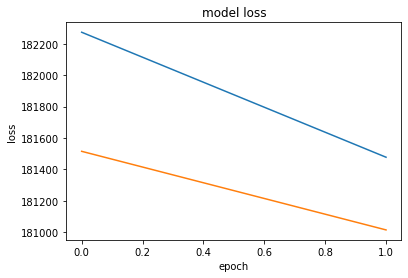

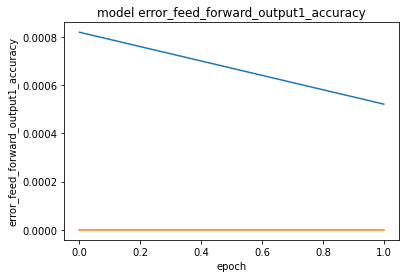

acc length:  360
name:  LNout0_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.01145833358168602
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.01197916641831398
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout1_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0017113095382228494
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0009672619053162634
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout2_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.histor

name:  LNout45_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout46_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout47_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history

name:  LNout114_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout115_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout116_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(hist

np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0071428571827709675
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout146_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout147_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'n

name:  LNout239_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout240_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.00014880952949170023
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.00022321428696159273
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout241_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.h

np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout274_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.00044642857392318547
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  LNout275_accuracy
np.asarray(acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.as

np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout36_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout37_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.his

np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout67_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0007102272938936949
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0014204545877873898
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout68_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0007102272938936949
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>

np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout192_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout193_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarr

np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout254_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout255_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout256_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(h

np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout356_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'numpy.ndarray'>
name:  val_LNout357_accuracy
np.asarray(val_acc) shape:  (360,)
np.asarray(history.history[name] type:  <class 'numpy.ndarray'>
np.asarray(history.history[name] shape:  (2,)
np.asarray(history.history[name][0] :  0.0
np.asarray(history.history[name][0] type :  <class 'numpy.ndarray'>
np.asarray(history.history[name][1] :  0.0
np.asarray(history.history[name][1] type :  <class 'nu

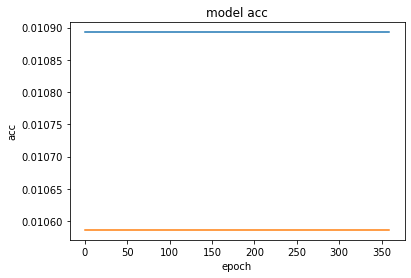

Model training completed...
Saving model...


C:\Users\W.R_Chen\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saving completed...


In [19]:
x=TestTranslate()
x.test_translate()

In [20]:
#set model para
model_name = "test_model1.h5"
x_test_model = "x_test_500.npy" 
y_test_mdodel1 = "y_test0_500.npy" 
y_test_mdodel2 = "y_test1_500.npy" 

In [21]:
#load model
def loadmodel(model_name, x_test_model, y_test_mdodel1, y_test_mdodel2):
    import numpy as np
    #load model and dic ps. dic is not use
    model, source_token_dict = load(model_name)
    #print(model.summary())
    #load
    
    '''
    Para:
        x_test_loaded  : answer model        (include type and lineblock)
        y_test_loaded_0: predict model       (type)
        y_test_loaded_1: predict model       (lineblock)
        out1           : answer model output (type) 
        out2           : answer model output (lineblock)
    '''
    
    x_test_loaded = loadTestTrainData("test_models/" + x_test_model) 
    y_test_loaded_0 = loadTestTrainData("test_models/" + y_test_mdodel1)
    y_test_loaded_1 = loadTestTrainData("test_models/" + y_test_mdodel2) 
    
    ''' <-------dust switch
    print("y_test_loaded_1 shape: ", y_test_loaded_1.shape)
    print("x_test_loaded length: ", len(x_test_loaded))
    #'''
    
    out1, out2 = tfr.decode(model,x_test_loaded, max_len = x.getsource_max_lan())
    
    #==============show org result================
    ''' <-------dust switch
    print("y_test_loaded_0 shape: ", y_test_loaded_0.shape)
    print("y_test_loaded_1 shape: ", y_test_loaded_1.shape)
    print("y_test_loaded_0[0] result:", (y_test_loaded_0[0])) #Error_type #vs out1
    print("y_test_loaded_1[0][1] result:", (y_test_loaded_1[0][1])) #Line_Block #vs out2
    print("out1 shape: ", (out1).shape)#prob upper then 0.5
    print("out2[0] shape: ", (out2[0]).shape)#prob upper then 0.5
    print("out2 length: ", len(out2))
    print("out2[0] length: ", len(out2[0]))#prob lb
    #'''
    
    #=============================================
    test_ep = np.around(out1)
    test_lb = np.around(out2)
    ans_ep = np.around(y_test_loaded_0)
    ans_lb = np.around(y_test_loaded_1)
    #==============show toint result==============
    
    ''' <-------dust switch
    print(test_ep[1])
    print(test_lb[1])
    print(ans_ep[1])
    print([ans_lb[1]])
    #'''
    #=============================================
    return test_ep, ans_ep, test_lb, ans_lb

In [22]:
def intersect(pre_errortype, ans_errortype):
    #print("inter :", pre_errortype)
    #print("inter: ", ans_errortype)
    #ans_errortype = float(ans_errortype)
    #ref = "https://www.796t.com/post/Mjc4am8=.html"
    inter = [pre_value for pre_value, ans_value in zip(pre_errortype, ans_errortype) if (pre_value == ans_value == 1)]
    inter_two = [pre_value for pre_value, ans_value in zip(pre_errortype, ans_errortype) if (pre_value == ans_value)]
    #print("sort inter: ", inter)
    return inter, inter_two

In [23]:
#get new ans array contains only 1 in array 
def ans_typefilter(ans_errortype):
    #print("org ans type: ", ans_errortype)
    new_ans_errortype = [value for value in ans_errortype if value == 1]
    #print("new ans errortype: ", new_ans_errortype)
    return new_ans_errortype

In [24]:
#get new pre array contains only 1 in array 
def pre_typefilter(pre_errortype):
    #print("org error type: ", pre_errortype)
    new_pre_errortype = [value for value in pre_errortype if value == 1]
    #print("new pre errortype: ", new_pre_errortype)
    return new_pre_errortype

In [25]:
#calculate error type score
#Note:
    #Predict score:
        # score = inter of ans and pre divide by len of pre
    #Recall score:
        # score = inter of ans and pre divide by len of ans
    #Accuracy score:
        # score = inter_two of ans and pre divide by original len of pre
def errortype_score(pre_errortype, ans_errortype):
    #find pre length
    new_pre_errortype = pre_typefilter(pre_errortype) #make new array for score
    pre_length = len(new_pre_errortype) #get lenght from ans_type
    #find ans length
    new_ans_errortype = ans_typefilter(ans_errortype) #make new array for score
    ans_length = len(new_ans_errortype) #get lenght from ans_type
    #print("ans length: ", ans_length)
    inter, inter_two = intersect(pre_errortype, ans_errortype) #get intersection
    inter_length = len(inter)
    inter_two_length = len(inter_two)
    #print("inter_length: ", inter_length)
    #print("pre length: ", pre_length) 
    
    #calculate Predict score 
    if (inter_length == 0 and pre_length == 0):
        pre_score = 1
    elif (pre_length == 0):
        pre_score = 0
    else:
        pre_score = inter_length/pre_length 
    #print("predict score: ", pre_score) #show pre score
    
    #calculate Recall score
    if (inter_length == 0 and ans_length == 0):
        rec_score = 1
    elif (ans_length == 0):
        rec_score = 0
    else:
        rec_score = inter_length/ans_length
    #print("recall score: ", rec_score) #show ans score
    
    #calculate Accuarcy score
    acc_score = inter_two_length/len(pre_errortype)
    
    return pre_score, rec_score , acc_score#return float

In [26]:
#show total perdict score and recall score
def errortype_totalscore(pre_errortype,ans_errortype):
    #initial para
    pre_total = 0.0
    rec_total = 0.0
    acc_total = 0.0
    #get each score then get total and avg score
    for i in range(len(pre_errortype)):
        #print("Sample: ", i)
        pre, rec, acc = errortype_score(pre_errortype[i], ans_errortype[i])
        pre_total = pre_total + pre
        rec_total = rec_total + rec
        acc_total = acc_total + acc
    print("pre_total: ", pre_total)
    print("rec_total: ", rec_total)
    print("acc_total: ", acc_total)
    pre_avg_score = pre_total/len(pre_errortype)
    rec_avg_socre = rec_total/len(ans_errortype)
    acc_avg_score = acc_total/len(ans_errortype)
    print("avg_pre: ", pre_avg_score)#pre_total/len(pre_errortype))
    print("avg_rec: ", rec_avg_socre)#rec_total/len(ans_errortype))
    print("avg_acc: ", acc_avg_score)#acc_total/len(ans_errortype))
    return pre_avg_score, rec_avg_socre, acc_avg_score

In [27]:
def get_start_end_line(pre_begin_index, pre_end_index, ans_begin_index, ans_end_index):
    #Note:
            #use softmax: [0.....150] total == 1
            #begin: index[0]
            #end: index[0]
        
    #get [value] first and get [value] again to get value
    pre_begin_line = pre_begin_index[0]
    pre_begin_line = pre_begin_line[0]
    pre_end_line = pre_end_index[0]
    pre_end_line = pre_end_line[0]
    ans_begin_line = ans_begin_index[0]
    ans_begin_line = ans_begin_line[0]
    ans_end_line = ans_end_index[0]
    ans_end_line = ans_end_line[0]
    
    return pre_begin_line, pre_end_line, ans_begin_line, ans_end_line

In [28]:
def line_adjustment(line):
    if(line > 1):
        line = line-1
        return line
    else:
        return line

In [29]:
# get each pre and ans lineblocks and make them to pre begin/end ans begin/end array
def make_lineblock(begin, end):
    if (end < begin):
        block = [value for value in range(end, begin+1)]
        return block
    else:
        block = [value for value in range(begin, end+1)]
        return block

In [30]:
# ref = "https://www.geeksforgeeks.org/python-intersection-two-lists/"
def lineblock_intersect(pre_block, ans_block):
    inter = [value for value in pre_block if value in ans_block]
    return inter

In [31]:
# return index with int datatype 
def get_block_index(pre_begins, pre_ends, ans_begins, ans_ends):
    pre_begin = int(pre_begins)
    pre_end = int(pre_ends)
    ans_begin = int(ans_begins)
    ans_end = int(ans_ends)
    #print(pre_begin, pre_end, ans_begin, ans_end)
    return pre_begin, pre_end, ans_begin, ans_end

In [32]:
#get new pre array contains only 1 in array 
def linefilter(line_block):
    #print("org error type: ", pre_errortype)
    new_line = [value for value in line_block if value == 1]
    #print("new pre errortype: ", new_pre_errortype)
    return new_line

In [33]:
 #Note:
    #Predict score:
        # score = inter of ans and pre divide by len of pre
    #Recall score:
        # score = inter of ans and pre divide by len of ans
    #                 b   s   l
    #line sturcture [84][36][150]
def errorline_totalscore(pre_errorline, ans_errorline):
    #get sample size
    sample_size = len(pre_errorline[1])
    #get block size
    lineblock_size = len(pre_errorline)
    total_pre = 0.0
    total_rec = 0.0
    total_sample_pre = 0.0
    total_sample_rec = 0.0
    for sample in range(sample_size):
        sample_totalline_pre = 0.0
        sample_totalline_rec = 0.0
        for lineblock in range(0, lineblock_size, 2):
            #give index blocks value
            pre_begin = pre_errorline[lineblock][sample]
            pre_end = pre_errorline[lineblock+1][sample]
            ans_begin = ans_errorline[lineblock][sample]
            ans_end = ans_errorline[lineblock+1][sample]
            ''' <-------dust switch
            #show error block value
            print("pre_errorline begin[lineblock][sample]: ", lineblock, " ", sample)
            print(pre_begin)
            print("pre_errorline begin[lineblock][sample]: ", lineblock+1, " ", sample)
            print(pre_end)
            print("ans_errorline begin [lineblock][sample]: ", lineblock, " ", sample)
            print(ans_begin)
            print("ans_errorline end[lineblock][sample]: ", lineblock+1, " ", sample)
            print(ans_end)
            #'''
            #get block start/end index
            pre_begin_index = np.where(pre_begin == 1)
            pre_end_index = np.where(pre_end == 1)
            ans_begin_index = np.where(ans_begin == 1)
            ans_end_index = np.where(ans_end == 1)
            ''' <-------dust switch
            #show start/end index
            print("pre_begin_index: ", pre_begin_index)
            print("pre_begin_index type: ", type(pre_begin_index))
            print("pre_end_index: ", pre_end_index)
            print("ans_begin_index: ", ans_begin_index)
            print("ans_end_index: ", ans_end_index)
            #'''
            #give start value
            #Note:
                #use softmax: [0.....150] total == 1
                #begin: index[0]
                #end: index[0]

            #get [value] first and get [value] again to get value
            pre_begin_line, pre_end_line, ans_begin_line, ans_end_line = get_start_end_line(
                                                                                            pre_begin_index, 
                                                                                            pre_end_index, 
                                                                                            ans_begin_index, 
                                                                                            ans_end_index
                                                                                            )
            ''' <-------dust switch
            #show start/end index
            print("pre_begin_line: ", pre_begin_line)
            print("pre_end_line: ", pre_end_line)
            print("ans_begin_line: ", ans_begin_line)
            print("ans_end_line: ", ans_end_line)
            #'''
            ''' <-------dust switch
            #'''
            #make line downgrade for 1
            #Note:
            #before:  0 -1  1  2  3  4
            #after:   0  1 <-----abs  
                        #1  2  3  4
                    #[0, 1, 2, 3, 4, 5]
            pre_begin_line = line_adjustment(pre_begin_line)
            pre_end_line = line_adjustment(pre_end_line)
            ans_begin_line = line_adjustment(ans_begin_line)
            ans_end_line = line_adjustment(ans_end_line)
            ''' <-------dust switch
            print("pre_begin_line: ", pre_begin_line)
            print("pre_end_line: ", pre_end_line)
            print("ans_begin_line: ",ans_begin_line)
            print("ans_end_line: ", ans_end_line)
            #'''
            pre_lineblock = make_lineblock(pre_begin_line, pre_end_line)
            ans_lineblock = make_lineblock(ans_begin_line, ans_end_line)
            #print("pre_lineblock: ", pre_lineblock)
            #print("ans_lineblock: ", ans_lineblock)
            inter = lineblock_intersect(pre_lineblock, ans_lineblock)
            #print("inter: ", inter)
            inter_length = len(inter)
            pre_length = len(pre_lineblock)
            ans_length = len(ans_lineblock)
            #print("inter length: ", inter_length)
            #print("pre_length: ", pre_length)
            #print("ans_length: ", ans_length)
            #count pre_score
            if (inter_length == 0 and pre_length == 0):
                pre_score = 1
            elif (pre_length == 0):
                pre_score = 0
            else :
                pre_score = inter_length/pre_length
            #count rec_score
            if (inter_length == 0 and ans_length == 0):
                rec_score = 1  
                #
            elif (ans_length == 0):
                rec_score = 0
            else:
                rec_score = inter_length/ans_length
            #print("Sample pre_score: ", pre_score)
            #print("Sample rec_score: ", rec_score)
            #cal each sample lineblock score
            sample_totalline_pre += pre_score
            sample_totalline_rec += rec_score
            #print("Sample total_pre: ", sample_pre)
            #print("Sample total_rec: ", sample_rec)
        #cal total sample score
        total_sample_pre += sample_totalline_pre/len(lineblock_size/2)
        total_sample_rec += sample_totalline_rec/len(lineblock_size/2)
    avg_pre = total_sample_pre/sample_size
    avg_rec = total_sample_rec/sample_size
    return avg_pre, avg_rec

In [34]:
def error_type_F_score(pre_score, rec_score):
    f_one = (2*pre_score*rec_score)/(pre_score + rec_score)
    f_two = (3*pre_score*rec_score)/((2*pre_score) + rec_score)
    f_pointfive = (3*pre_score*rec_score)/(pre_score + (2*rec_score))
    print("F_one: ", f_one)
    print("F_two: ", f_two)
    print("F_pointfive: ", f_pointfive)
    

In [35]:
def error_line_F_score(pre_score, rec_score):
    f_one = (2*pre_score*rec_score)/(pre_score + rec_score)
    f_two = (3*pre_score*rec_score)/((2*pre_score) + rec_score)
    f_pointfive = (3*pre_score*rec_score)/(pre_score + (2*rec_score))
    print("F_one: ", f_one)
    print("F_two: ", f_two)
    print("F_pointfive: ", f_pointfive)


In [36]:
pre_errortype, ans_errortype, pre_errorline, ans_errorline = loadmodel(model_name, x_test_model, y_test_mdodel1, y_test_mdodel2)
#print(len(pre_errortype))

'''
work : 
    fix 3 dim prob: 
        out2 only show two dim
        score need three dim: out2: 2D, y_test_loaded_1: 3D
    issue:
        y_test_loaded_1: dim is not expected...
    ==================================================================================
    expect :
    y_test_loaded_0 : [sample = 36][error type = 36] correct v
    out1 :            [sample = 36][error type = 36] correct v
    y_test_loaded_1 : [sample = 36][block = 84][begin and end :line total = 150]
    out2 :            [sample = 36][block = 84][begin and end :line total = 150]
    ==================================================================================
    real : 
            out2 shape            = [36][150]    ------>dim should be [36][84][150]
            y_test_loaded_1 shape = [84][36][150]------>dim should be [36][84][150]
    ==================================================================================
    ref in line work space
'''


FileNotFoundError: [Errno 2] No such file or directory: 'source_token_dict.pickle'

In [ ]:
#check all sample error type score
avg_pre, avg_rec, avg_acc = errortype_totalscore(pre_errortype, ans_errortype)
error_type_F_score(avg_pre, avg_rec)

In [ ]:
#check all sample error line score
avg_pre, avg_rec = errorline_totalscore(pre_errorline, ans_errorline)
error_line_F_score(avg_pre, avg_rec)

In [ ]:
#work space...


import numpy as np 
#len(ans_errortype)
sample_size = len(pre_errorline[1])
lineblock_size = len(pre_errorline)
'''
Note:
    pre_errorline[lineblock][sample]
    ans_errorline[lineblock][sample]
Para:
'''


#''' <-------dust switch
print("sample size: ", sample_size)
print("lineblock size: ", lineblock_size)
#'''
total_pre_score = 0.0
total_rec_score = 0.0
for sample in range(sample_size):
    for lineblock in range(0, lineblock_size, 2):
        #give index blocks value
        pre_begin = pre_errorline[lineblock][sample]
        pre_end = pre_errorline[lineblock+1][sample]
        ans_begin = ans_errorline[lineblock][sample]
        ans_end = ans_errorline[lineblock+1][sample]
        
        ''' <-------dust switch
        #show error block value
        print("pre_errorline begin[lineblock][sample]: ", lineblock, " ", sample)
        print(pre_begin)
        print("pre_errorline begin[lineblock][sample]: ", lineblock+1, " ", sample)
        print(pre_end)
        print("ans_errorline begin [lineblock][sample]: ", lineblock, " ", sample)
        print(ans_begin)
        print("ans_errorline end[lineblock][sample]: ", lineblock+1, " ", sample)
        print(ans_end)
        #'''
        #get block start/end index
        pre_begin_index = np.where(pre_begin == 1)
        pre_end_index = np.where(pre_end == 1)
        ans_begin_index = np.where(ans_begin == 1)
        ans_end_index = np.where(ans_end == 1)
        
        ''' <-------dust switch
        #show start/end index
        print("pre_begin_index: ", pre_begin_index)
        print("pre_begin_index type: ", type(pre_begin_index))
        print("pre_end_index: ", pre_end_index)
        print("ans_begin_index: ", ans_begin_index)
        print("ans_end_index: ", ans_end_index)
        #'''
        
        #give start value
        #Note:
            #use softmax: [0.....150] total == 1
            #begin: index[0]
            #end: index[0]
        
        #get [value] first and get [value] again to get value
        #pre_begin_line, pre_end_line, ans_begin_line, ans_end_line = get_start_end_line(pre_begin_index, pre_end_index, ans_begin_index, ans_end_index)
        
        pre_begin_line = pre_begin_index[0]
        #pre_begin_line = pre_begin_line[0]
        pre_end_line = pre_end_index[0]
        #pre_end_line = pre_end_line[0]
        ans_begin_line = ans_begin_index[0]
        ans_begin_line = ans_begin_line[0]
        ans_end_line = ans_end_index[0]
        ans_end_line = ans_end_line[0]
        
        #''' <-------dust switch
        #show start/end index
        print("pre_begin_line: ", pre_begin_line)
        print("pre_end_line: ", pre_end_line)
        print("ans_begin_line: ", ans_begin_line)
        print("ans_end_line: ", ans_end_line)
        #'''
        
        
        
        #make intersection
        
        ''' <-------dust switch
        print("inter_begin: ", inter_begin)
        print("inter_all_begin: ", inter_all_begin)
        #'''
        
        
'''
final decide: find index and build ----> [1 2 3 4 5 6] vs [2 3 4 5 6 7] to make intercestion
'''

In [ ]:
#Note:
    #Predict score:
        # score = inter of ans and pre divide by len of pre
    #Recall score:
        # score = inter of ans and pre divide by len of ans
    #Accuracy score:
        # score = inter_two of ans and pre divide by original len of pre

#case 1:  n  n vs  n  n 
#case 2:  n  n vs -1 -1
#case 3: -1 -1 vs -1 -1
#case 4: -1  n vs  n  n
#case 5: -1  n vs -1  n
pre_begin_line = 5
pre_end_line = 7
ans_begin_line = 3
ans_end_line = 2
pre_begin_line = line_adjustment(pre_begin_line)
pre_end_line = line_adjustment(pre_end_line)
ans_begin_line = line_adjustment(ans_begin_line)
ans_end_line = line_adjustment(ans_end_line)

print("pre_begin_line: ", pre_begin_line)
print("pre_end_line: ", pre_end_line)
print("ans_begin_line: ",ans_begin_line)
print("ans_end_line: ", ans_end_line)
pre_lineblock = make_lineblock(pre_begin_line, pre_end_line)
ans_lineblock = make_lineblock(ans_begin_line, ans_end_line)
print("pre_lineblock: ", pre_lineblock)
print("ans_lineblock: ", ans_lineblock)
inter = lineblock_intersect(pre_lineblock, ans_lineblock)
print("inter: ", inter)
inter_length = len(inter)
pre_length = len(pre_lineblock)
ans_length = len(ans_lineblock)
print("inter length: ", inter_length)
print("pre_length: ", pre_length)
print("ans_length: ", ans_length)
if (inter_length == 0 and pre_length == 0):
    pre_score = 1
    # issue 7.12ver 
elif (pre_length == 0):
    pre_score = 0
else :
    pre_score = inter_length/pre_length
#    
if (inter_length == 0 and ans_length == 0):
    rec_score = 1  
    #
elif (ans_length == 0):
    rec_score = 0
else:
    rec_score = inter_length/ans_length
#print("Sample pre_score: ", pre_score)
total_pre += pre_score
#print("Sample rec_score: ", rec_score)
total_rec += rec_score
#print("Sample total_pre: ", total_pre)
#print("Sample total_rec: ", total_rec)
avg_pre = total_pre/len(pre_begins)
avg_rec = total_rec/len(ans_begins)


In [ ]:
import glob
Input_Path = "Trianing\InputTxt\Split-500"
Input_Path = (glob.glob(Input_Path+"/**/*.txt"))
for i in range(10):
    print(Input_Path[i])